<br>
<font>
<div dir=ltr align=center>
<font color=0F5298 size=7>
    System 2 - Homework 3<br>
<font color=2565AE size=5>
    Spring 2025<br>
<font color=3C99D size=5>
    LLM Agent <br>

*`Full Name:`* ...

*`SID:`* ...


----

# 🤖📘 Welcome to the *LLM + Agents* Learning Notebook!

This interactive notebook is designed to help you **build intelligent agents** that leverage the power of **Large Language Models (LLMs)** and **Vision-Language Models (VLMs)** to reason about visual data and answer questions.

---

## 🚀 What You'll Learn

✅ Load and explore a visual question answering dataset  
✅ Work with a powerful VLM (`QwenVLM`)  
✅ Build a **judge model** to assess answer correctness  
✅ Perform **zero-shot evaluation** of an LLM-based agent  
✅ ✨ **Design and implement your own agent** that can reason step-by-step  

---

You'll incrementally complete missing components in code cells, guided by clear instructions. Use your creativity to make your agent smarter!

> 💡 *Tip: Don’t hesitate to explore how prompting affects the agent’s behavior.*

---

### 🔧 Setup

Make sure you have the right environment, dependencies installed, and access to the required models.

Now, let’s start building!


# HW3 - Agents

## Load Dataset

In [ ]:
!unzip agent_data.zip


```markdown
**Guideline:** The following code cell that loads the dataset has been removed. Please write code to:
1. Load the CSV file `agent_data/data.csv` into a pandas DataFrame.
2. Display the first few rows to verify that the data has been loaded correctly.
```

In [ ]:
import pandas as pd

# Complete this part


Image                                           question  answer
0    2085  What is the shape of the object that is furthe...  square
1   14958  Is the yellow object on the top or on the bottom?  bottom
2   11507     Is the red object on the left or on the right?   right
3    5798  Is the yellow object on the left or on the right?   right
4    1289              What is the shape of the blue object?  circle
..    ...                                                ...     ...
95  13711  What is the color of the object that is closes...     red
96  16494  What is the color of the object that is closes...    gray
97  18117  What is the color of the object that is closes...   green
98  18342  What is the color of the object that is closes...     red
99   3152               What is the shape of the red object?  square

[100 rows x 3 columns]

In [3]:
x = data['question'].to_list()
y = data['answer'].to_list()
image_list = data['Image'].to_list()

image_list = ['agent_data/images/'+str(i)+'.png' for i in image_list]

```markdown
**Guideline:** Please:
1. Implement a function named `show_data(i, x, y, image_list)` that:
   - Prints the question `x[i]` and its corresponding answer `y[i]`.
   - Displays the image at `image_list[i]` using `matplotlib`.
2. Call this function for index `0` to visualize a sample from the dataset.
```

What is the shape of the object that is furthest from the gray object?
square


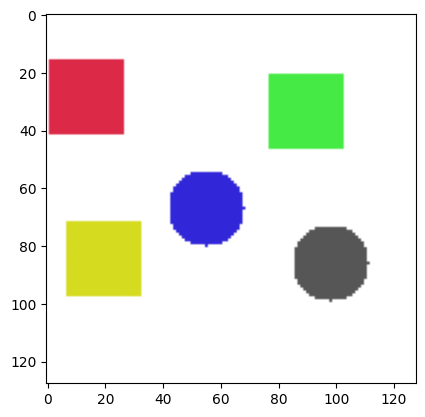

In [ ]:
import matplotlib.pyplot as plt

# Complete this part

## Load LVLM

In [5]:
!pip install qwen-vl-utils[decord]==0.0.8

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.3/35.3 MB 48.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 91.1 MB/s eta 0:00:00


```markdown
**Guideline:** In the following cell, you will see how to load a pretrained Vision-Language Model (VLM) using the `transformers` library and related utilities.
- Carefully read the code to understand:
  1. How the model and processor are initialized.
  2. How input images and prompts are preprocessed.
  3. How `model.generate` is used to produce text outputs.
- Be prepared to explain:
  - The role of `AutoProcessor` and `Qwen2_5_VLForConditionalGeneration`.
  - Why we trim generated token IDs before decoding.
```

In [ ]:
import torch
from PIL import Image
from transformers import AutoProcessor, Qwen2_5_VLForConditionalGeneration
from qwen_vl_utils import process_vision_info


class QwenVLM:
    def __init__(self, model_name="Qwen/Qwen2.5-VL-3B-Instruct", device="cuda"):
        # Load the model
        self.model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
            model_name,
            torch_dtype="auto",
            device_map="auto"
        )

        # Load the processor
        self.processor = AutoProcessor.from_pretrained(model_name)

        # Set device
        self.device = device

    def inference(self, prompt="Describe this image.", image_path=None, max_new_tokens=128):
        if image_path:
            # Load image from local path
            image = Image.open(image_path).convert("RGB")

            # Construct messages in chat format with image
            messages = [
                {
                    "role": "user",
                    "content": [
                        {"type": "image", "image": image},
                        {"type": "text", "text": prompt},
                    ],
                }
            ]

            # Prepare text input
            text = self.processor.apply_chat_template(
                messages, tokenize=False, add_generation_prompt=True
            )

            # Prepare image/video inputs
            image_inputs, video_inputs = process_vision_info(messages)

            # Tokenize inputs
            inputs = self.processor(
                text=[text],
                images=image_inputs,
                videos=video_inputs,
                padding=True,
                return_tensors="pt",
            ).to(self.device)

        else:
            # Text-only mode
            messages = [
                {
                    "role": "user",
                    "content": [
                        {"type": "text", "text": prompt},
                    ],
                }
            ]

            text = self.processor.apply_chat_template(
                messages, tokenize=False, add_generation_prompt=True
            )

            inputs = self.processor(
                text=[text],
                padding=True,
                return_tensors="pt",
            ).to(self.device)

        # Generate output
        generated_ids = self.model.generate(**inputs, max_new_tokens=max_new_tokens)
        generated_ids_trimmed = [
            out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
        ]

        # Decode output
        output_text = self.processor.batch_decode(
            generated_ids_trimmed,
            skip_special_tokens=True,
            clean_up_tokenization_spaces=False,
        )
        return output_text

vlm = QwenVLM()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.37k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/65.4k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model-00002-of-00002.safetensors:   0%|          | 0.00/3.53G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/3.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/216 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/5.70k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

### Example

In [7]:
vlm.inference(image_path=image_list[0])

['The image shows five colored shapes arranged in a row from left to right:\n\n1. A red square.\n2. A green rectangle.\n3. A yellow triangle.\n4. A blue circle.\n5. A black dot.\n\nEach shape is distinct in color and form, creating a simple yet colorful composition.']

## LLM as a judge

```markdown
**Guideline:** Your task:
1. Design a prompt template that takes:
   - The question.
   - The model's answer.
   - The ground truth answer.
   And asks the LLM to determine if the model's answer implies the ground truth answer.
2. Implement `judge(vlm, question, model_answer, ground_truth)` to:
   - Construct and send your prompt to the VLM.
   - Parse the VLM's "Yes"/"No" response into a binary `1` (correct) or `0` (incorrect).
```

In [ ]:
def judge(vlm, question, text1, text2):
    # Complete this part 
    pass

### Example

In [ ]:

judge(vlm, "what is the shape of object?","square", "I think shape of object is square")


1

In [ ]:
# In this part should check the evalution procedure with negative examples 
judge(vlm, "what is the shape of object?", "square", "the object is blue")


0

## zero-shot

```markdown
**Guideline:** Implement the zero-shot evaluation loop:
1. For each index `i` in the dataset:
   - Use `vlm.inference(image_path=image_list[i], prompt=x[i])` to get the model's prediction.
   - Store the prediction in `pred`.
   - Call `judge(vlm, x[i], pred[-1], y[i])` to obtain a binary assessment of correctness.
   - Append the judge's result to `true_pred`.
2. Use `tqdm` to monitor progress.
```

In [ ]:
from tqdm import tqdm

pred = []
true_pred = []

# This should be implemented by the students 
for i in tqdm(range(len(x))):
    # Complete this part



  0%|          | 0/100 [00:00<?, ?it/s]

['The object that is furthest from the gray object is the red square.']



  1%|          | 1/100 [00:01<02:56,  1.78s/it]

['The yellow object is on the bottom.']



  2%|▏         | 2/100 [00:02<02:17,  1.41s/it]

['The red object is on the right.']



  3%|▎         | 3/100 [00:04<02:04,  1.29s/it]

['The yellow object is on the left.']



  4%|▍         | 4/100 [00:05<01:58,  1.23s/it]

['The blue object in the image is a circle.']



  5%|▌         | 5/100 [00:06<01:58,  1.25s/it]

['The object that is furthest from the green object is the blue circle.']



  6%|▌         | 6/100 [00:08<02:07,  1.36s/it]

['The object that is furthest from the red object is the blue square.']



  7%|▋         | 7/100 [00:09<02:11,  1.41s/it]

['The blue object is on the left.']



  8%|▊         | 8/100 [00:10<02:03,  1.34s/it]

['The yellow object is on the bottom.']



  9%|▉         | 9/100 [00:12<02:01,  1.34s/it]

['The object that is closest to the gray object is red.']



 10%|█         | 10/100 [00:13<02:03,  1.37s/it]

['The object that is closest to the green object is blue.']



 11%|█         | 11/100 [00:14<02:02,  1.37s/it]

['The object that is closest to the yellow object is red.']



 12%|█▏        | 12/100 [00:16<02:00,  1.37s/it]

['The object that is closest to the red object is yellow.']



 13%|█▎        | 13/100 [00:17<01:59,  1.37s/it]

['The object that is furthest from the red object is the green circle.']



 14%|█▍        | 14/100 [00:19<02:02,  1.43s/it]

['The red object is on the bottom.']



 15%|█▌        | 15/100 [00:20<01:54,  1.35s/it]

['The object that is furthest from the gray object is the yellow square.']



 16%|█▌        | 16/100 [00:21<01:58,  1.41s/it]

['The object that is closest to the red object is yellow.']



 17%|█▋        | 17/100 [00:23<02:01,  1.46s/it]

['The object that is furthest from the blue object is the yellow circle.']



 18%|█▊        | 18/100 [00:25<02:07,  1.56s/it]

['The object that is furthest from the yellow object is a square.']



 19%|█▉        | 19/100 [00:26<02:04,  1.54s/it]

['The blue object is on the bottom.']



 20%|██        | 20/100 [00:27<01:54,  1.43s/it]

['The object that is closest to the green object is yellow.']



 21%|██        | 21/100 [00:29<01:52,  1.42s/it]

['The object that is furthest from the blue object is the green circle.']



 22%|██▏       | 22/100 [00:30<01:54,  1.46s/it]

['The object closest to the green square is the yellow circle.']



 23%|██▎       | 23/100 [00:32<01:51,  1.44s/it]

['The object that is closest to the red object is yellow.']



 24%|██▍       | 24/100 [00:33<01:48,  1.43s/it]

['The object that is closest to the blue object is green.']



 25%|██▌       | 25/100 [00:35<01:49,  1.46s/it]

['The gray object is on the right.']



 26%|██▌       | 26/100 [00:36<01:45,  1.43s/it]

['The green object in the picture is a circle.']



 27%|██▋       | 27/100 [00:37<01:40,  1.38s/it]

['The red object is on the top.']



 28%|██▊       | 28/100 [00:39<01:35,  1.32s/it]

['The blue object is on the left.']



 29%|██▉       | 29/100 [00:40<01:30,  1.28s/it]

['The shape of the object that is furthest from the yellow object is a square.']



 30%|███       | 30/100 [00:41<01:38,  1.40s/it]

['The green object is on the bottom.']



 31%|███       | 31/100 [00:43<01:32,  1.34s/it]

['The object that is furthest from the gray object is the yellow square.']



 32%|███▏      | 32/100 [00:44<01:35,  1.41s/it]

['The object that is closest to the blue object is yellow.']



 33%|███▎      | 33/100 [00:46<01:33,  1.40s/it]

['The object that is closest to the red object is yellow.']



 34%|███▍      | 34/100 [00:47<01:37,  1.48s/it]

['The object that is closest to the yellow object is blue.']



 35%|███▌      | 35/100 [00:49<01:35,  1.47s/it]

['The yellow object is a circle.']



 36%|███▌      | 36/100 [00:50<01:27,  1.37s/it]

['The red object is on the top.']



 37%|███▋      | 37/100 [00:51<01:22,  1.31s/it]

['The object that is closest to the red object is yellow.']



 38%|███▊      | 38/100 [00:52<01:23,  1.34s/it]

['The object that is closest to the yellow object is red.']



 39%|███▉      | 39/100 [00:54<01:23,  1.37s/it]

['The object that is closest to the red object is yellow.']



 40%|████      | 40/100 [00:55<01:22,  1.38s/it]

['The object that is furthest from the yellow object is the blue square.']



 41%|████      | 41/100 [00:57<01:24,  1.44s/it]

['The object that is closest to the gray object is blue.']



 42%|████▏     | 42/100 [00:58<01:24,  1.45s/it]

['The object that is closest to the yellow object is green.']



 43%|████▎     | 43/100 [01:00<01:26,  1.52s/it]

['The object that is closest to the yellow object is blue.']



 44%|████▍     | 44/100 [01:01<01:22,  1.48s/it]

['The object that is closest to the green object is blue.']



 45%|████▌     | 45/100 [01:03<01:20,  1.46s/it]

['The gray object is a square.']



 46%|████▌     | 46/100 [01:04<01:13,  1.36s/it]

['The object that is closest to the blue object is yellow.']



 47%|████▋     | 47/100 [01:05<01:13,  1.39s/it]

['The object that is closest to the blue object is yellow.']



 48%|████▊     | 48/100 [01:07<01:12,  1.40s/it]

['The object that is furthest from the red object is the green circle.']



 49%|████▉     | 49/100 [01:08<01:14,  1.45s/it]

['The object that is closest to the red object is yellow.']



 50%|█████     | 50/100 [01:10<01:12,  1.45s/it]

['The object that is furthest from the blue object is a yellow circle.']



 51%|█████     | 51/100 [01:12<01:17,  1.58s/it]

['The object that is closest to the yellow object is blue.']



 52%|█████▏    | 52/100 [01:13<01:13,  1.53s/it]

['The yellow object is on the top.']



 53%|█████▎    | 53/100 [01:14<01:07,  1.43s/it]

['The object that is closest to the red object is blue.']



 54%|█████▍    | 54/100 [01:16<01:05,  1.43s/it]

['The yellow object is on the right.']



 55%|█████▌    | 55/100 [01:17<01:01,  1.36s/it]

['The green object is on the left.']



 56%|█████▌    | 56/100 [01:18<00:57,  1.31s/it]

['The yellow object is on the left.']



 57%|█████▋    | 57/100 [01:19<00:54,  1.28s/it]

['The blue object is on the left.']



 58%|█████▊    | 58/100 [01:21<00:52,  1.26s/it]

['The object that is closest to the red object is green.']



 59%|█████▉    | 59/100 [01:22<00:55,  1.34s/it]

['The red object is on the left.']



 60%|██████    | 60/100 [01:23<00:54,  1.36s/it]

['The shape of the object that is furthest from the blue object is a square.']



 61%|██████    | 61/100 [01:25<00:57,  1.47s/it]

['The blue object is on the right.']



 62%|██████▏   | 62/100 [01:26<00:52,  1.39s/it]

['The object that is furthest from the red object is the green circle.']



 63%|██████▎   | 63/100 [01:28<00:53,  1.45s/it]

['The yellow object is on the left.']



 64%|██████▍   | 64/100 [01:29<00:49,  1.38s/it]

['The object that is closest to the blue object is green.']



 65%|██████▌   | 65/100 [01:31<00:48,  1.40s/it]

['The object that is furthest from the gray object is the yellow square.']



 66%|██████▌   | 66/100 [01:32<00:49,  1.46s/it]

['The green object is on the right.']



 67%|██████▋   | 67/100 [01:34<00:46,  1.40s/it]

['The object that is closest to the red object is blue.']



 68%|██████▊   | 68/100 [01:35<00:47,  1.47s/it]

['The object that is closest to the gray object is red.']



 69%|██████▉   | 69/100 [01:37<00:45,  1.46s/it]

['The object that is closest to the red object is yellow.']



 70%|███████   | 70/100 [01:38<00:43,  1.45s/it]

['The gray object is on the bottom.']



 71%|███████   | 71/100 [01:39<00:40,  1.38s/it]

['The gray object is on the left.']



 72%|███████▏  | 72/100 [01:40<00:37,  1.33s/it]

['The green object is on the right.']



 73%|███████▎  | 73/100 [01:42<00:35,  1.30s/it]

['The red object is on the bottom.']



 74%|███████▍  | 74/100 [01:43<00:33,  1.27s/it]

['The object that is closest to the red object is the gray one.']



 75%|███████▌  | 75/100 [01:44<00:33,  1.35s/it]

['The object that is closest to the gray object is yellow.']



 76%|███████▌  | 76/100 [01:46<00:34,  1.43s/it]

['The green object is on the top.']



 77%|███████▋  | 77/100 [01:47<00:32,  1.40s/it]

['The gray object in the image is a square.']



 78%|███████▊  | 78/100 [01:49<00:30,  1.38s/it]

['The gray object is on the top.']



 79%|███████▉  | 79/100 [01:50<00:27,  1.33s/it]

['The object that is closest to the gray object is the green one.']



 80%|████████  | 80/100 [01:51<00:27,  1.39s/it]

['The gray object is on the right.']



 81%|████████  | 81/100 [01:53<00:25,  1.34s/it]

['The object that is closest to the gray object is yellow.']



 82%|████████▏ | 82/100 [01:54<00:24,  1.37s/it]

['The object that is furthest from the red object is the blue circle.']



 83%|████████▎ | 83/100 [01:56<00:24,  1.44s/it]

['The object that is closest to the red object is the blue one.']



 84%|████████▍ | 84/100 [01:57<00:23,  1.49s/it]

['The object that is closest to the red object in the image is the yellow one.']



 85%|████████▌ | 85/100 [01:59<00:24,  1.64s/it]

['The object that is furthest from the gray object is the blue circle.']



 86%|████████▌ | 86/100 [02:01<00:22,  1.62s/it]

['The object that is closest to the red object is yellow.']



 87%|████████▋ | 87/100 [02:02<00:20,  1.57s/it]

['The object that is closest to the blue object is red.']



 88%|████████▊ | 88/100 [02:04<00:18,  1.52s/it]

['The object that is closest to the green object is red.']



 89%|████████▉ | 89/100 [02:05<00:16,  1.49s/it]

['The blue object is on the left.']



 90%|█████████ | 90/100 [02:06<00:14,  1.40s/it]

['The yellow object is on the right.']



 91%|█████████ | 91/100 [02:08<00:12,  1.35s/it]

['The object that is closest to the red object is yellow.']



 92%|█████████▏| 92/100 [02:09<00:11,  1.38s/it]

['The green object is on the right.']



 93%|█████████▎| 93/100 [02:10<00:09,  1.38s/it]

['The object that is furthest from the blue object is the green circle.']



 94%|█████████▍| 94/100 [02:12<00:08,  1.44s/it]

['The object that is closest to the yellow object is the black object.']



 95%|█████████▌| 95/100 [02:14<00:07,  1.48s/it]

['The object that is closest to the yellow object is the red square.']



 96%|█████████▌| 96/100 [02:15<00:05,  1.49s/it]

['The object that is closest to the green object is the blue one.']



 97%|█████████▋| 97/100 [02:17<00:04,  1.51s/it]

['The object that is closest to the red object is green.']



 98%|█████████▊| 98/100 [02:18<00:02,  1.48s/it]

['The object that is closest to the green object is the red square.']



 99%|█████████▉| 99/100 [02:20<00:01,  1.50s/it]

['The red object in the picture is a square.']


100%|██████████| 100/100 [02:21<00:00,  1.41s/it]


In [ ]:
# Calculate the total accuracy


Accuracy: 0.46


## Build your own agent

### Classic agents

```markdown
**Guideline:**
In the following you need use classic image processing techniques using opencv packages in addition to LLMs. Your agents should be classic approaches to process images and create a appropriate prompt for LLMs.

In this section, given the constraint that agents must rely on classical approaches, your task is to implement a set of agents along with a verifier. The goal is to design a system (whether in a single execution or through a loop) that improves your VLM's ability to solve the problem.

You're free to adjust the code structure or change the number of agents depending on what your solution requires.

What's most important here is your creativity in designing the agents. For instance, you might start with an agent that detects the question type (e.g., whether it begins with "what is" or "is the"). Based on that, different agents can follow to handle specific tasks. For example, another agent might specialize in detecting object colors. By combining such agents, you can gradually build an effective system.

In [ ]:
import cv2
import numpy as np
from typing import List, Tuple


def query_vlm(prompt: str, image_path: str) -> str:
    return vlm.inference(image_path=image_path, prompt=prompt)


def agent1(prompt: str, image_path: str) -> Tuple[str, str]:
    # Complete this part
    return prompt, image_path

def agent2(prompt: str, image_path: str) -> Tuple[str, str]:
    # Complete this part
    return prompt, image_path

def agent3(prompt: str, image_path: str) -> Tuple[str, str]:
    # Complete this part
    return prompt, image_path

def generate_prompt(prompt: str, image_path: str) -> Tuple[str, str]:
    # Complete this part
    return prompt, image_path


# Verifier
def verify_response(prompt: str, image_path: str, response: str) -> bool:
    # Complete this part

    return 

# Agent Loop with Verifier
def agent_loop(question: str, image_path: str, max_retries=1):
    retries = 0

    while retries < max_retries:
       # complete this part


from tqdm import tqdm

pred = []
true_pred = []


for i in tqdm(range(len(x))):
    pred.append(agent_loop(image_path=image_list[i], question=x[i]))
    print(pred[-1])
    true_pred.append(judge(vlm, x[i], pred[-1], y[i]))


  0%|          | 0/100 [00:00<?, ?it/s]

['The object that is furthest from the gray object is the square in red, located at coordinates (13, 28).']



  1%|          | 1/100 [00:02<04:09,  2.52s/it]

['The yellow object is on the bottom.']



  2%|▏         | 2/100 [00:03<02:59,  1.83s/it]

['The red object is on the right.']



  3%|▎         | 3/100 [00:05<02:43,  1.69s/it]

['The yellow object is on the right.']



  4%|▍         | 4/100 [00:06<02:28,  1.55s/it]

['The blue object in the image is a circle. Therefore, the correct answer is:\n\ncircle, blue, (23,91)']



  5%|▌         | 5/100 [00:09<02:56,  1.86s/it]

['The object that is furthest from the green object is the square with coordinates (104, 96).']



  6%|▌         | 6/100 [00:11<03:08,  2.00s/it]

['The object that is furthest from the red circle is the square in the top left corner, which is blue and located at coordinates (49, 22). Therefore, the correct answer is:\n\nsquare, blue, (49,22)']



  7%|▋         | 7/100 [00:15<04:00,  2.59s/it]

['The blue object is on the left.']



  8%|▊         | 8/100 [00:16<03:27,  2.25s/it]

['The yellow object is on the bottom.']



  9%|▉         | 9/100 [00:18<03:02,  2.00s/it]

['The object that is closest to the gray object is the square with the coordinates (100, 24).']



 10%|█         | 10/100 [00:20<03:07,  2.08s/it]

['The object that is closest to the green object is the circle with coordinates (35, 92).']



 11%|█         | 11/100 [00:22<03:06,  2.10s/it]

['The object that is closest to the yellow object is:\n\nsquare, red, (57,79)']



 12%|█▏        | 12/100 [00:24<03:04,  2.10s/it]

['The object that is closest to the red object is a square, which is located at coordinates (105, 103). Therefore, the correct answer is:\n\nsquare, yellow, (49,105)']



 13%|█▎        | 13/100 [00:28<03:41,  2.55s/it]

['The object that is furthest from the red object is the square in the top left corner, which is colored yellow and has coordinates (90, 34). Therefore, the correct answer is:\n\nsquare, yellow, (90,34)']



 14%|█▍        | 14/100 [00:32<04:18,  3.00s/it]

['The red object is on the bottom.']



 15%|█▌        | 15/100 [00:33<03:32,  2.50s/it]

['The object that is furthest from the gray object is the square with the yellow color, located at coordinates (48, 25).']



 16%|█▌        | 16/100 [00:36<03:30,  2.50s/it]

['The object that is closest to the red object is a square, and its coordinates are (93, 83). Therefore, the correct answer is:\n\nsquare, red, (93,83)']



 17%|█▋        | 17/100 [00:39<03:47,  2.74s/it]

['The object that is furthest from the blue square is the circle in red color. Therefore, the correct answer is:\n\ncircle, red, (85,38)']



 18%|█▊        | 18/100 [00:42<03:58,  2.90s/it]

['The object that is furthest from the yellow object is the square, which is located at coordinates (37, 106).']



 19%|█▉        | 19/100 [00:45<03:44,  2.77s/it]

['The blue object is on the bottom.']



 20%|██        | 20/100 [00:46<03:06,  2.33s/it]

['The object that is closest to the green object is:\n\nsquare, yellow, (111,87)']



 21%|██        | 21/100 [00:48<03:00,  2.28s/it]

['The object that is furthest from the blue square is the yellow square. Therefore, the correct answer is:\n\nyellow, (110,97)']



 22%|██▏       | 22/100 [00:51<03:08,  2.41s/it]

['The object that is closest to the green square is the circle with the coordinates (18, 107).']



 23%|██▎       | 23/100 [00:53<03:10,  2.47s/it]

['The object that is closest to the red square is the one with coordinates (54, 69). Therefore, the correct answer is:\n\nsquare, red, (54, 69)']



 24%|██▍       | 24/100 [00:57<03:24,  2.69s/it]

['The object that is closest to the blue object is a circle, yellow, located at coordinates (106, 35).']



 25%|██▌       | 25/100 [00:59<03:15,  2.60s/it]

['The gray object is on the right.']



 26%|██▌       | 26/100 [01:00<02:44,  2.22s/it]

['The green object in the image is a circle with coordinates (49, 106). Therefore, the correct answer is:\n\ncircle, green, (49,106)']



 27%|██▋       | 27/100 [01:04<03:03,  2.52s/it]

['The red object is on the top.']



 28%|██▊       | 28/100 [01:05<02:40,  2.22s/it]

['The blue object is on the right.']



 29%|██▉       | 29/100 [01:06<02:18,  1.95s/it]

['The object that is furthest from the yellow object is the square in red with coordinates (17,15).']



 30%|███       | 30/100 [01:09<02:22,  2.04s/it]

['The green object is on the bottom.']



 31%|███       | 31/100 [01:10<02:05,  1.83s/it]

['The object that is furthest from the gray object is the square with the color yellow, located at coordinates (87, 18).']



 32%|███▏      | 32/100 [01:13<02:19,  2.05s/it]

['The object that is closest to the blue object is a square, which is black and located at coordinates (66, 42).']



 33%|███▎      | 33/100 [01:15<02:25,  2.18s/it]

['The object that is closest to the red square is:\n\n- **circle, green, (106,25)**\n\nThis is because the green circle is positioned at coordinates (106, 25), which is closer to the red square than any other option provided.']



 34%|███▍      | 34/100 [01:20<03:10,  2.88s/it]

['The object that is closest to the yellow object in the image is a square with a blue color and coordinates (55, 73).']



 35%|███▌      | 35/100 [01:22<03:00,  2.77s/it]

['The yellow object in the image is a circle. Therefore, the correct answer is:\n\ncircle, yellow, (39,97)']



 36%|███▌      | 36/100 [01:25<02:50,  2.67s/it]

['The red object is on the top.']



 37%|███▋      | 37/100 [01:26<02:22,  2.27s/it]

['The object that is closest to the red object in the image is a circle with a green color. Therefore, the correct answer is:\n\ncircle, green, (64,78)']



 38%|███▊      | 38/100 [01:29<02:43,  2.64s/it]

['The object that is closest to the yellow object is a square, red, located at coordinates (16, 80).']



 39%|███▉      | 39/100 [01:32<02:35,  2.55s/it]

['The object that is closest to the red square is the yellow square, which is located at coordinates (21, 65). Therefore, the correct answer is:\n\nsquare, yellow, (21,65)']



 40%|████      | 40/100 [01:35<02:48,  2.81s/it]

['The object that is furthest from the yellow object is the square with the coordinates (88, 38).']



 41%|████      | 41/100 [01:37<02:35,  2.63s/it]

['The object that is closest to the gray object is the circle colored blue, located at coordinates (33, 72).']



 42%|████▏     | 42/100 [01:40<02:33,  2.65s/it]

['The object that is closest to the yellow object in the image is a circle with a green color and coordinates (14, 86).']



 43%|████▎     | 43/100 [01:43<02:29,  2.62s/it]

['The object that is closest to the yellow object is:\n\ncircle, blue, (19,92)']



 44%|████▍     | 44/100 [01:45<02:18,  2.48s/it]

['The object that is closest to the green square is:\n\ncircle, red, (106,47)']



 45%|████▌     | 45/100 [01:47<02:11,  2.38s/it]

['The gray object is a square with a black fill. Its coordinates are given as (17, 54). Therefore, the correct answer is:\n\nsquare, black, (17,54)']



 46%|████▌     | 46/100 [01:50<02:22,  2.64s/it]

['The object that is closest to the blue object is a square with a red color and coordinates (35, 33).']



 47%|████▋     | 47/100 [01:53<02:21,  2.66s/it]

['The object that is closest to the blue object in the image is a circle, which is yellow. Therefore, the correct answer is:\n\ncircle, yellow, (49,42)']



 48%|████▊     | 48/100 [01:56<02:24,  2.77s/it]

['The object that is furthest from the red object is the circle with coordinates (112, 102).']



 49%|████▉     | 49/100 [01:58<02:13,  2.62s/it]

['The object that is closest to the red object in the image is:\n\nsquare, yellow, (22,61)']



 50%|█████     | 50/100 [02:00<02:05,  2.52s/it]

['The object that is furthest from the blue object is the circle with coordinates (89, 19).']



 51%|█████     | 51/100 [02:03<01:59,  2.44s/it]

['The object closest to the yellow one is the blue one. Therefore, the correct answer is:\n\ncircle, blue, (49,46)']



 52%|█████▏    | 52/100 [02:06<02:02,  2.56s/it]

['The yellow square is on the top.']



 53%|█████▎    | 53/100 [02:07<01:42,  2.19s/it]

['The object that is closest to the red object in the image is:\n\nsquare, yellow, (75,71)']



 54%|█████▍    | 54/100 [02:09<01:41,  2.22s/it]

['The yellow object is on the right.']



 55%|█████▌    | 55/100 [02:10<01:27,  1.95s/it]

['The green object is on the left.']



 56%|█████▌    | 56/100 [02:12<01:17,  1.77s/it]

['The yellow object is on the left.']



 57%|█████▋    | 57/100 [02:13<01:10,  1.64s/it]

['The blue object is on the left.']



 58%|█████▊    | 58/100 [02:15<01:06,  1.58s/it]

['The object that is closest to the red object is a square, blue, located at coordinates (49, 92).']



 59%|█████▉    | 59/100 [02:17<01:17,  1.88s/it]

['The red object is on the left.']



 60%|██████    | 60/100 [02:19<01:08,  1.72s/it]

['The object that is furthest from the blue object is the square with the coordinates (110, 41).']



 61%|██████    | 61/100 [02:21<01:13,  1.89s/it]

['The blue object is on the right.']



 62%|██████▏   | 62/100 [02:22<01:05,  1.72s/it]

['The object that is furthest from the red object is the circle with the coordinates (58, 80). This circle is located in the top right quadrant of the image.']



 63%|██████▎   | 63/100 [02:25<01:17,  2.09s/it]

['The yellow object is on the left.']



 64%|██████▍   | 64/100 [02:27<01:08,  1.91s/it]

['The object that is closest to the blue object is a square with coordinates (104, 96).']



 65%|██████▌   | 65/100 [02:29<01:11,  2.05s/it]

['The object that is furthest from the gray object is the circle with the coordinates (108, 78).']



 66%|██████▌   | 66/100 [02:31<01:12,  2.13s/it]

['The green object is on the right.']



 67%|██████▋   | 67/100 [02:33<01:02,  1.88s/it]

['The object that is closest to the red object in the image is a circle, which is colored blue. Therefore, the correct answer is:\n\ncircle, blue, (60,58)']



 68%|██████▊   | 68/100 [02:36<01:11,  2.24s/it]

['The object that is closest to the gray object is a circle, which is red in color. Therefore, the correct answer is:\n\ncircle, red, (57,34)']



 69%|██████▉   | 69/100 [02:39<01:17,  2.51s/it]

['The object that is closest to the red object in the image is a circle with a green color and coordinates (85, 61).']



 70%|███████   | 70/100 [02:41<01:16,  2.55s/it]

['The gray object is on the top.']



 71%|███████   | 71/100 [02:43<01:03,  2.19s/it]

['The gray object is on the left.']



 72%|███████▏  | 72/100 [02:44<00:54,  1.93s/it]

['The green object is on the right.']



 73%|███████▎  | 73/100 [02:45<00:47,  1.75s/it]

['The red object is on the bottom.']



 74%|███████▍  | 74/100 [02:47<00:42,  1.63s/it]

['The object that is closest to the red object is a circle, black, located at coordinates (51, 57).']



 75%|███████▌  | 75/100 [02:49<00:45,  1.84s/it]

['The object that is closest to the gray square is the yellow circle. Therefore, the correct answer is:\n\ncircle, yellow, (20,111)']



 76%|███████▌  | 76/100 [02:52<00:53,  2.25s/it]

['The green object is on the top.']



 77%|███████▋  | 77/100 [02:54<00:45,  1.97s/it]

['The gray object in the image is a square. Therefore, the correct answer is:\n\nsquare, black, (40,12)']



 78%|███████▊  | 78/100 [02:56<00:46,  2.11s/it]

['The gray object is on the top.']



 79%|███████▉  | 79/100 [02:57<00:39,  1.87s/it]

['The object that is closest to the gray object is a circle, green, located at coordinates (49, 55).']



 80%|████████  | 80/100 [03:00<00:40,  2.01s/it]

['The gray object is on the right.']



 81%|████████  | 81/100 [03:01<00:34,  1.81s/it]

['The object that is closest to the gray square is the yellow square. Therefore, the correct answer is:\n\nsquare, yellow, (17,54)']



 82%|████████▏ | 82/100 [03:04<00:39,  2.20s/it]

['The object that is furthest from the red object is the circle with the color blue and coordinates (106,31).']



 83%|████████▎ | 83/100 [03:07<00:38,  2.26s/it]

['The object that is closest to the red object is a square with coordinates (20, 89).']



 84%|████████▍ | 84/100 [03:09<00:35,  2.21s/it]

['The object that is closest to the red object in the image is a circle with a yellow color and coordinates (65, 71).']



 85%|████████▌ | 85/100 [03:11<00:34,  2.30s/it]

['The object that is furthest from the gray object is the circle with the coordinates (112, 94). This circle is located at the top right corner of the image.']



 86%|████████▌ | 86/100 [03:14<00:36,  2.58s/it]

['The object that is closest to the red object is a square, which is yellow. Therefore, the correct answer is:\n\nsquare, yellow, (18,81)']



 87%|████████▋ | 87/100 [03:17<00:34,  2.68s/it]

['The object that is closest to the blue object is a circle, which is colored red. The coordinates for this circle are (13, 26).']



 88%|████████▊ | 88/100 [03:20<00:32,  2.68s/it]

['The object that is closest to the green object is a circle, and its coordinates are (66, 89). Therefore, the correct answer is:\n\ncircle, red, (66,89)']



 89%|████████▉ | 89/100 [03:23<00:31,  2.85s/it]

['The blue object is on the left.']



 90%|█████████ | 90/100 [03:25<00:23,  2.39s/it]

['The yellow object is on the right.']



 91%|█████████ | 91/100 [03:26<00:19,  2.14s/it]

['The object that is closest to the red square is the yellow circle. The coordinates for the yellow circle are (64, 93).']



 92%|█████████▏| 92/100 [03:29<00:18,  2.28s/it]

['The green object is on the right.']



 93%|█████████▎| 93/100 [03:30<00:13,  2.00s/it]

['The object that is furthest from the blue object is the yellow square, which is located at coordinates (57, 82).']



 94%|█████████▍| 94/100 [03:33<00:12,  2.13s/it]

['The object that is closest to the yellow object is a circle, which is black and located at coordinates (19, 67).']



 95%|█████████▌| 95/100 [03:35<00:11,  2.22s/it]

['The object that is closest to the yellow object is a square with coordinates (19, 104).']



 96%|█████████▌| 96/100 [03:37<00:08,  2.22s/it]

['The object that is closest to the green object is a circle, which is blue in color. Therefore, the correct answer is:\n\ncircle, blue, (82,68)']



 97%|█████████▋| 97/100 [03:40<00:07,  2.52s/it]

['The object that is closest to the red object is a square with a green color and coordinates (80, 50).']



 98%|█████████▊| 98/100 [03:43<00:04,  2.48s/it]

['The object that is closest to the green object in the image is:\n\nsquare, red, (29,29)']



 99%|█████████▉| 99/100 [03:45<00:02,  2.42s/it]

['The red object in the image is a square. Therefore, the correct answer is:\n\nsquare, red, (39,13)']


100%|██████████| 100/100 [03:47<00:00,  2.28s/it]


In [ ]:
# Calculate the total accuracy


Accuracy: 0.61


### Ablation Study

```markdown
In this part, you need to test the impact of each agent by removing them one by one to assess how much each contributes to the system’s accuracy. Your goal is to optimize the system and identify the most effective configuration. You should also include a written analysis explaining the role of each agent and justify why it's necessary based on its performance.

In [ ]:
# complete this part


### DL Agents

```markdown
**Guideline:** In the Deep Learning Agents section, you will develop enhanced agents using LLM techniques. For each agent (`agent1`, `agent2`, `agent3`):
1. Modify the agent function to:
   - Here, you need to using Deep Learning techniques to build agents beside LLM.
   - Generate an intermediate reasoning step or sub-prompt via the VLM.
   - Use that reasoning to produce a final answer tuple `(intermediate, final)`.
2. Ensure that `agent_loop` integrates these steps to iteratively refine answers based on VLM feedback.

In this section, given the constraint that agents must rely on Deep Learning approaches, your task is to implement a set of agents along with a verifier. The goal is to design a system (whether in a single execution or through a loop) that improves your VLM's ability to solve the problem.

You're free to adjust the code structure or change the number of agents depending on what your solution requires.

What's most important here is your creativity in designing the agents. For instance, you might start with an agent that detects the question type (e.g., whether it begins with "what is" or "is the"). Based on that, different agents can follow to handle specific tasks. For example, another agent might specialize in instance segmentation (e.g. Segment Anything Model (SAM) model). By combining such agents, you can gradually build an effective system.
```


In [ ]:
import numpy as np
from typing import List, Tuple


def query_vlm(prompt: str, image_path: str) -> str:
    return vlm.inference(image_path=image_path, prompt=prompt)


def agent1(prompt: str, image_path: str) -> Tuple[str, str]:
    # Complete this part
    return prompt, image_path

def agent2(prompt: str, image_path: str) -> Tuple[str, str]:
    # Complete this part
    return prompt, image_path

def agent3(prompt: str, image_path: str) -> Tuple[str, str]:
    # Complete this part
    return prompt, image_path

def generate_prompt(prompt: str, image_path: str) -> Tuple[str, str]:
    # Complete this part
    return prompt, image_path


# Verifier
def verify_response(prompt: str, image_path: str, response: str) -> bool:
    # Complete this part

    return 

# Agent Loop with Verifier
def agent_loop(question: str, image_path: str, max_retries=1):
    retries = 0

    while retries < max_retries:
       # complete this part


from tqdm import tqdm

pred = []
true_pred = []


for i in tqdm(range(len(x))):
    pred.append(agent_loop(image_path=image_list[i], question=x[i]))
    print(pred[-1])
    true_pred.append(judge(vlm, x[i], pred[-1], y[i]))

In [ ]:
# Calculate the total accuracy


### Ablation Study

```markdown
In this part, you need to test the impact of each agent by removing them one by one to assess how much each contributes to the system’s accuracy. Your goal is to optimize the system and identify the most effective configuration. You should also include a written analysis explaining the role of each agent and justify why it's necessary based on its performance.

In [ ]:
# complete this part


## 🎯 Final Educational Objectives

In the final step, you should present your analysis by comparing the zero-shot approach with the two agent-driven systems you've built. Your comparison should cover not only the final accuracy but also other factors like execution time.


By the end of this notebook, you will be able to:

- ✅ Understand how LLMs can act as intelligent agents.
- ✅ Apply multimodal models to structured reasoning tasks.
- ✅ Evaluate the outputs of models using self-judging agents.
- ✅ Build your **own agent pipeline** and apply intermediate reasoning steps.
- ✅ Reflect on how prompting and architecture influence results.

---

🎓 *This notebook equips you with essential skills to work on cutting-edge AI systems that combine vision, language, and planning.*
